In [1]:
"""
Exercise 16.14.2: Combining NumPy, Pandas, and GeoPandas
Complete solution for all 6 tasks
"""

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# ============================================================
# TASK 1: Load world cities dataset using Pandas
# ============================================================
print("Task 1: Loading world cities dataset...")

url = "https://github.com/opengeos/datasets/releases/download/world/world_cities.csv"
df = pd.read_csv(url)

print(f"✓ Loaded {len(df)} cities")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

c:\Users\AKHTAR HUSSAIN\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Task 1: Loading world cities dataset...


URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

In [ ]:
# TASK 2: Filter cities with latitude between -40 and 60
print("\nTask 2: Filtering cities by latitude...")
# Filter using NumPy/Pandas boolean indexing
# Keep cities where latitude is between -40 and 60
filtered_df = df[(df['latitude'] >= -40) & (df['latitude'] <= 60)].copy()

print(f"✓ Original cities: {len(df)}")
print(f"✓ Filtered cities: {len(filtered_df)}")
print(f"✓ Removed: {len(df) - len(filtered_df)} cities (Southern Hemisphere extremes)")

# Show the range of latitudes in filtered data
print(f"\nLatitude range in filtered data:")
print(f"  Min: {filtered_df['latitude'].min()}")
print(f"  Max: {filtered_df['latitude'].max()}")



Task 2: Filtering cities by latitude...
✓ Original cities: 1249
✓ Filtered cities: 1132
✓ Removed: 117 cities (Southern Hemisphere extremes)

Latitude range in filtered data:
  Min: -39.795
  Max: 59.93901


In [ ]:
# TASK 3: Create GeoDataFrame from lat/lon
print("\nTask 3: Creating GeoDataFrame...")

# Create geometry column from latitude and longitude
# Point takes (x, y) which is (longitude, latitude)
geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]

# Create GeoDataFrame with WGS84 coordinate system (EPSG:4326)
gdf = gpd.GeoDataFrame(
    filtered_df, 
    geometry=geometry,
    crs="EPSG:4326"  # Standard GPS coordinate system
)

print(f"✓ Created GeoDataFrame with {len(gdf)} cities")
print(f"✓ CRS: {gdf.crs}")
print(f"\nGeoDataFrame info:")
print(gdf.head())



Task 3: Creating GeoDataFrame...
✓ Created GeoDataFrame with 1132 cities
✓ CRS: EPSG:4326

GeoDataFrame info:
   id         name country  latitude  longitude  population  \
0   1        Bombo     UGA    0.5833    32.5333       75000   
1   2  Fort Portal     UGA    0.6710    30.2750       42670   
2   3      Potenza     ITA   40.6420    15.7990       69060   
3   4   Campobasso     ITA   41.5630    14.6560       50762   
4   5        Aosta     ITA   45.7370     7.3150       34062   

                 geometry  
0  POINT (32.5333 0.5833)  
1    POINT (30.275 0.671)  
2   POINT (15.799 40.642)  
3   POINT (14.656 41.563)  
4    POINT (7.315 45.737)  


In [ ]:
# TASK 4: Reproject to Mercator projection (EPSG:3857)
print("\nTask 4: Reprojecting to Mercator (EPSG:3857)...")
# Reproject to Web Mercator (used by Google Maps, etc.)
gdf_mercator = gdf.to_crs(epsg=3857)

print(f"✓ Reprojected to: {gdf_mercator.crs}")
print(f"✓ New coordinates (sample):")
print(gdf_mercator[['name', 'geometry']].head())

# Note: Coordinates are now in meters instead of degrees
original_coords = gdf.iloc[0].geometry
mercator_coords = gdf_mercator.iloc[0].geometry
print(f"\nExample coordinate transformation:")
print(f"  Original (WGS84): {original_coords.x:.4f}, {original_coords.y:.4f} (degrees)")
print(f"  Mercator (3857):  {mercator_coords.x:.2f}, {mercator_coords.y:.2f} (meters)")


Task 4: Reprojecting to Mercator (EPSG:3857)...
✓ Reprojected to: EPSG:3857
✓ New coordinates (sample):
          name                         geometry
0        Bombo     POINT (3621590.39 64933.781)
1  Fort Portal    POINT (3370197.584 74697.086)
2      Potenza  POINT (1758736.635 4959679.293)
3   Campobasso  POINT (1631498.457 5095742.084)
4        Aosta   POINT (814302.075 5738302.989)

Example coordinate transformation:
  Original (WGS84): 32.5333, 0.5833 (degrees)
  Mercator (3857):  3621590.39, 64933.78 (meters)


In [ ]:
# TASK 5: Calculate distance from each city to Paris
print("\nTask 5: Calculating distances to Paris...")

# Find Paris in the dataset
paris = gdf_mercator[gdf_mercator['name'].str.lower() == 'paris']

if len(paris) == 0:
    print("⚠ Paris not found by exact match, searching for partial match...")
    paris = gdf_mercator[gdf_mercator['name'].str.contains('Paris', case=False, na=False)]

print(f"✓ Found Paris: {paris[['name', 'country', 'latitude', 'longitude']].to_string()}")

# Get Paris geometry (point in Mercator projection)
paris_point = paris.geometry.iloc[0]
print(f"✓ Paris coordinates (Mercator): {paris_point.x:.2f}, {paris_point.y:.2f}")

# Calculate distance from each city to Paris (in meters)
# Using geopandas .distance() method - automatically uses projected coordinates
gdf_mercator['distance_to_paris_m'] = gdf_mercator.geometry.distance(paris_point)

# Convert to kilometers for easier reading
gdf_mercator['distance_to_paris_km'] = gdf_mercator['distance_to_paris_m'] / 1000

print(f"\nDistance statistics:")
print(gdf_mercator['distance_to_paris_km'].describe())

# Show closest and farthest cities
closest = gdf_mercator.nsmallest(5, 'distance_to_paris_km')[['name', 'country', 'distance_to_paris_km']]
farthest = gdf_mercator.nlargest(5, 'distance_to_paris_km')[['name', 'country', 'distance_to_paris_km']]

print(f"\n5 closest cities to Paris:")
print(closest.to_string())

print(f"\n5 farthest cities from Paris:")
print(farthest.to_string())




Task 5: Calculating distances to Paris...
✓ Found Paris:        name country  latitude  longitude
1241  Paris     FRA  48.86669    2.33334
✓ Paris coordinates (Mercator): 259746.22, 6252271.67

Distance statistics:
count     1132.000000
mean      9138.689318
std       4451.607577
min          0.000000
25%       5817.566781
50%       9399.160744
75%      12159.909048
max      22353.345271
Name: distance_to_paris_km, dtype: float64

5 closest cities to Paris:
         name country  distance_to_paris_km
1241    Paris     FRA              0.000000
37    Orleans     FRA            168.997484
38      Rouen     FRA            169.325549
40     Amiens     FRA            176.808536
39      Reims     FRA            199.800788

5 farthest cities from Paris:
           name country  distance_to_paris_km
400      Napier     NZL          22353.345271
402    Hamilton     NZL          22076.282599
401     Manukau     NZL          21983.325313
1203   Auckland     NZL          21961.500924
1051  Nukual


Task 6: Creating map visualization...
✓ Saved: task6_cities_distance.png


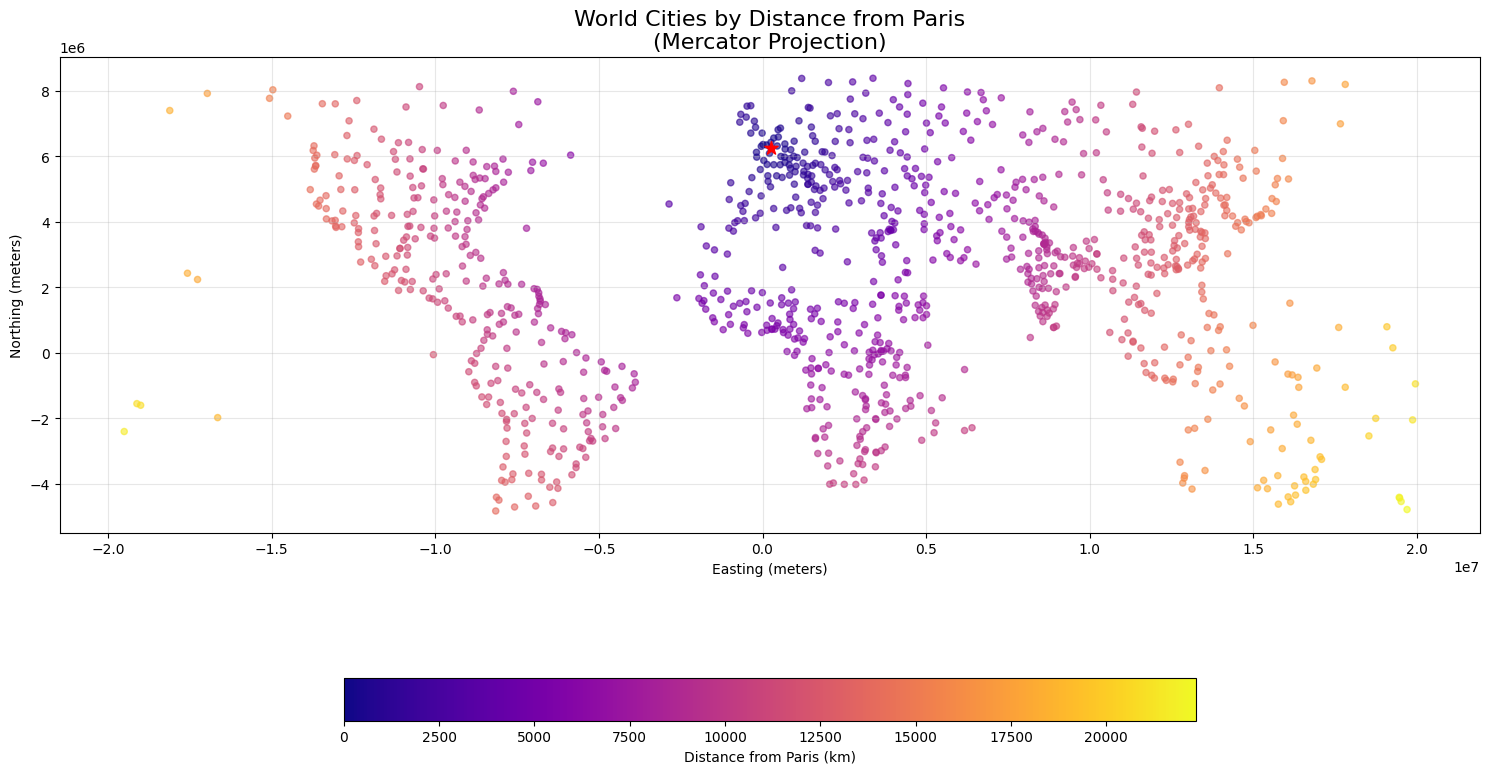

In [ ]:
print("\nTask 6: Creating map visualization...")

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot using gdf_mercator (NOT gdf!) - this has the distance column
gdf_mercator.plot(
    column='distance_to_paris_km',  # Now this column exists!
    cmap='plasma',
    legend=True,
    legend_kwds={
        'label': "Distance from Paris (km)",
        'orientation': "horizontal",
        'shrink': 0.6
    },
    markersize=20,
    alpha=0.6,
    ax=ax
)

# Highlight Paris in red (use gdf_mercator version)
paris_mercator = gdf_mercator[gdf_mercator['name'].str.contains('Paris', case=False, na=False)]
paris_mercator.plot(
    color='red',
    markersize=100,
    marker='*',
    label='Paris',
    ax=ax
)

ax.set_title('World Cities by Distance from Paris\n(Mercator Projection)', fontsize=16)
ax.set_xlabel('Easting (meters)')
ax.set_ylabel('Northing (meters)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task6_cities_distance.png', dpi=300)
print("✓ Saved: task6_cities_distance.png")
plt.show()

In [ ]:
import os

print("\n" + "="*50)
print("FILE LOCATIONS")
print("="*50)

# Get current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# List all files created by this script
files_to_check = [
    'task6_cities_distance.png',
    'task6_cities_distance_from_paris.png', 
    'task6_cities_wgs84.png',
    'task6_wgs84.png',
    'task2_nyc_buildings_static.png',
    'task3_nyc_buildings_interactive.html'
]

print(f"\nLooking for files in: {current_dir}")
print("-" * 50)

for filename in files_to_check:
    filepath = os.path.join(current_dir, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"✅ FOUND: {filename} ({size:.1f} KB)")
        print(f"   Full path: {filepath}")
    else:
        print(f"❌ NOT FOUND: {filename}")

print("="*50)


FILE LOCATIONS
Current directory: c:\Users\AKHTAR HUSSAIN\AppData\Local\Programs\Microsoft VS Code

Looking for files in: c:\Users\AKHTAR HUSSAIN\AppData\Local\Programs\Microsoft VS Code
--------------------------------------------------
✅ FOUND: task6_cities_distance.png (1137.3 KB)
   Full path: c:\Users\AKHTAR HUSSAIN\AppData\Local\Programs\Microsoft VS Code\task6_cities_distance.png
✅ FOUND: task6_cities_distance_from_paris.png (1127.1 KB)
   Full path: c:\Users\AKHTAR HUSSAIN\AppData\Local\Programs\Microsoft VS Code\task6_cities_distance_from_paris.png
❌ NOT FOUND: task6_cities_wgs84.png
❌ NOT FOUND: task6_wgs84.png
❌ NOT FOUND: task2_nyc_buildings_static.png
❌ NOT FOUND: task3_nyc_buildings_interactive.html
